# 4강. 이미지 어디까지 우려볼까?

## 4-2. Augmentation 적용 (1) 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# stanford_dogs 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


- [stanford_dogs dataset](https://www.tensorflow.org/datasets/catalog/stanford_dogs) : 20,580장 중 train set 12,000장, test set 8,580장

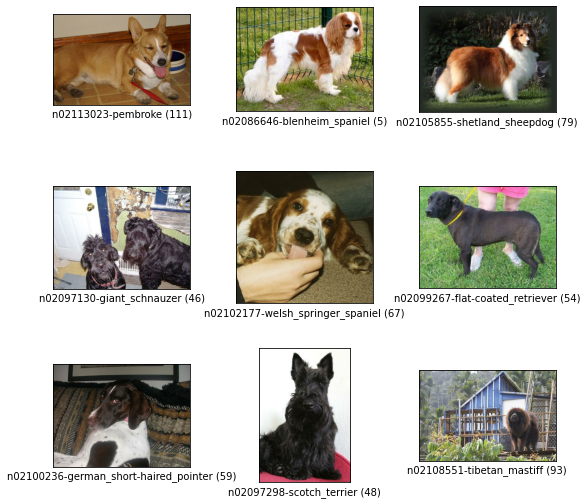

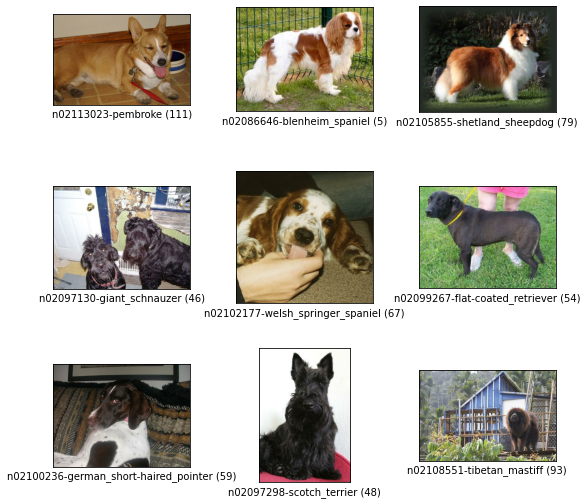

In [4]:
# 다운로드 한 데이터 확인
tfds.show_examples(ds_train, ds_info)

## 4-3. Augmentation 적용 (2) Augmentation 적용하기
### 텐서플로우 Random Augmentation API 사용하기
<span style='background-color: #fff5b1'>텐서플로우 API random augmentation 함수</span>  
- random_brightness()  
- random_contrast()  
- random_crop()  
- random_flip_left_right()  
- random_flip_up_down()  
- random_hue()  
- random_jpeg_quality()  
- random_saturation()  

In [5]:
# 기본적인 전처리 함수 만들기
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224]) # (224, 224) 사이즈로 resize
    return tf.cast(image, tf.float32) / 255., label # 0~1 사이의 float32로 normalize

- 전처리 함수 형태
![전처리함수형태](https://user-images.githubusercontent.com/116326867/212227291-a286ac08-b93e-42f5-8015-187eb1d6972f.png)

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 좌우대칭
    image = tf.image.random_brightness(image, max_delta=0.2) # 명도조절
    image = tf.clip_by_value(image, 0, 1)
    return image, label
# 상하대칭은 의미가 없을 듯하여 추가하지 않음

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- apply_normalize_on_dataset() : normalize, resize, augmentation과 shuffle(일반적인 전처리 과정)이 담긴 함수. 주의할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 것이다.  
- with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있다. -> [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)  
- cf. [test-time augmentation](https://hwiyong.tistory.com/215) : 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 방법

### Random Augmentation 구현하기

In [8]:
# 다른 random augmentation 함수 만들어보기
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## 4-4. Augmentation 적용 (3) 비교실험 하기
- augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능 비교하기

In [9]:
# ResNet50 : imagenet으로 훈련된 모델 불러오기
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


- include_top : 마지막 fully connected layer를 포함할지 여부. 이미지넷(ImageNet)과 현재 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문에 해당 레이어를 포함하지 않고 생성하여 특성 추출기(feature extractor) 부분만 불러와 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다.

In [10]:
# Augmentation을 적용하여 데이터셋을 학습시키기 위해 ResNet50 하나 더 만들기
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) # augmentation이 적용하지 않음
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) # augmentation이 적용함
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [12]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
#EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 193s 200ms/step - loss: 2.2065 - accuracy: 0.4448 - val_loss: 3.3913 - val_accuracy: 0.1927
Epoch 2/20
750/750 [==============================] - 167s 223ms/step - loss: 0.6979 - accuracy: 0.8090 - val_loss: 1.0224 - val_accuracy: 0.6924
Epoch 3/20
750/750 [==============================] - 152s 202ms/step - loss: 0.2192 - accuracy: 0.9565 - val_loss: 0.9455 - val_accuracy: 0.7161
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0678 - accuracy: 0.9923 - val_loss: 0.9350 - val_accuracy: 0.7280
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0294 - accuracy: 0.9987 - val_loss: 0.9295 - val_accuracy: 0.7304
Epoch 6/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0182 - accuracy: 0.9994 - val_loss: 0.9412 - val_accuracy: 0.7343
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0139 - accuracy: 0.9995 - val_loss: 0.9525 -

In [13]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 156s 199ms/step - loss: 2.2610 - accuracy: 0.4338 - val_loss: 2.7354 - val_accuracy: 0.3134
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.9354 - accuracy: 0.7322 - val_loss: 1.1051 - val_accuracy: 0.6669
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 0.5091 - accuracy: 0.8607 - val_loss: 1.0937 - val_accuracy: 0.6793
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 0.2821 - accuracy: 0.9308 - val_loss: 1.0805 - val_accuracy: 0.6897
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.1607 - accuracy: 0.9685 - val_loss: 0.9858 - val_accuracy: 0.7247
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0913 - accuracy: 0.9845 - val_loss: 0.9672 - val_accuracy: 0.7285
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0560 - accuracy: 0.9926 - val_loss: 0.9111 -

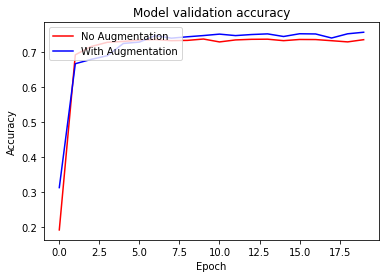

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

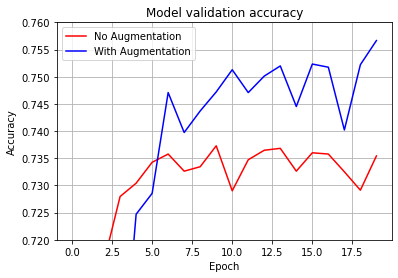

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당하다.
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위 지정
plt.show()

- Augmentation 적용한 경우가 적용하지 않은 경우보다 천천히 학습되지만, EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성된다.

## 4-5. 심화 기법 (1) Cutmix Augmentation
- [Cutmix](https://arxiv.org/pdf/1905.04899.pdf)  
- [Cutmix & Mixup](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)
- Mixup : 특정 비율로 픽셀별 값을 섞는 방식 / Cutout : 이미지를 잘라내는 방식 / CutMix : Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법(이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함한다.)

![cutmix](https://user-images.githubusercontent.com/116326867/212594170-db05ff00-f633-4f0b-a00d-5354a1d61114.png)

### 1) 이미지 섞기

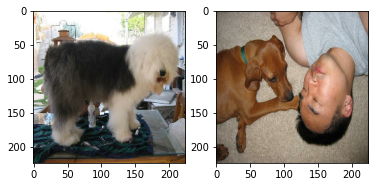

In [16]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져오기
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [17]:
# 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주기 위해
# 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 만들기
# width, height가 다르더라도 가변적으로 적용할 수 있도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(34, shape=(), dtype=int32) tf.Tensor(216, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(192, shape=(), dtype=int32)


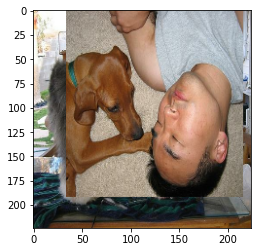

In [18]:
# mix two images(바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합침)
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기

In [19]:
# mix two labels(섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수)
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.6964286,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

- 이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 하는데, CutMix에서는 면적에 비례해서 라벨을 섞어준다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용한다.

In [20]:
# 배치 단위의 cutmix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 4-6. 심화 기법 (2) Mixup Augmentation
- [Mixup](https://arxiv.org/pdf/1710.09412.pdf)

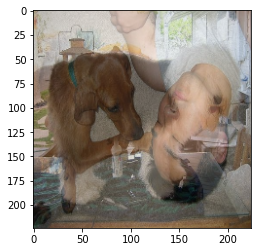

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.47221172
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.5277883  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [21]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주기

In [22]:
# 배치 단위의 mixup 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels